# WASP-80b: External data preparation 

## Overview

The HDF5 file `data/extrenal_lcs.h5` contains separate Pandas time series for each light curve. We simplify the passbands a bit and approximate...

    /lc/fukui2014/H/irsf_130716             frame        (shape->[537,7]) 
    /lc/fukui2014/H/irsf_130822             frame        (shape->[576,7]) 
    /lc/fukui2014/H/irsf_131007             frame        (shape->[597,7]) 
    /lc/fukui2014/J/irsf_130716             frame        (shape->[541,7]) 
    /lc/fukui2014/J/irsf_130822             frame        (shape->[566,7]) 
    /lc/fukui2014/J/irsf_131007             frame        (shape->[597,7]) 
    /lc/fukui2014/J/isle_130813             frame        (shape->[324,7]) 
    /lc/fukui2014/J/isle_130922             frame        (shape->[241,7]) 
    /lc/fukui2014/K/irsf_130716             frame        (shape->[539,7]) 
    /lc/fukui2014/K/irsf_130822             frame        (shape->[582,7]) 
    /lc/fukui2014/K/irsf_131007             frame        (shape->[603,7]) 
    /lc/fukui2014/g/oao50_130813            frame        (shape->[562,7]) 
    /lc/fukui2014/g/oao50_130922            frame        (shape->[268,7]) 
    /lc/fukui2014/i/oao50_130813            frame        (shape->[563,7]) 
    /lc/fukui2014/i/oao50_130922            frame        (shape->[295,7]) 
    /lc/fukui2014/r/oao50_130813            frame        (shape->[566,7]) 
    /lc/fukui2014/r/oao50_130922            frame        (shape->[290,7]) 
    /lc/mancini2014/H/grond                 series       (shape->[508])   
    /lc/mancini2014/J/grond                 series       (shape->[508])   
    /lc/mancini2014/K/grond                 series       (shape->[508])   
    /lc/mancini2014/g/grond                 series       (shape->[162])   
    /lc/mancini2014/i/dfosc                 series       (shape->[156])   
    /lc/mancini2014/i/grond                 series       (shape->[156])   
    /lc/mancini2014/r/grond                 series       (shape->[156])   
    /lc/mancini2014/z/grond                 series       (shape->[157])   
    /lc/triaud2013/r/eulercam_1             series       (shape->[208])   
    /lc/triaud2013/z/trappist_1             series       (shape->[721])   
    /lc/triaud2013/z/trappist_2             series       (shape->[704])   
    /transmission                           frame        (shape->[2151,7])

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyfits as pf
import pandas as pd
import seaborn as sb
from glob import glob
from os.path import basename, splitext

## Fukui et al. 2013

In [3]:
from exotk.utils.misc import fold
from extcore import TC, P, TZERO

In [4]:
ls data/fukui_2014/

irsf-H-130716.dat  irsf-J-130716.dat  irsf-K-130716.dat  isle-J-130813.dat   oao50-G-130922.dat  oao50-R-130813.dat
irsf-H-130822.dat  irsf-J-130822.dat  irsf-K-130822.dat  isle-J-130922.dat   oao50-I-130813.dat  oao50-R-130922.dat
irsf-H-131007.dat  irsf-J-131007.dat  irsf-K-131007.dat  oao50-G-130813.dat  oao50-I-130922.dat  TM_all.dat


In [5]:
fnames = sorted(glob('data/fukui_2014/[i,o]*dat'))
hnames = map(lambda s: 'lc/fukui2014/{t[1]:s}/{t[0]:s}_{t[2]:s}'.format(t=splitext(basename(s))[0].split('-')), fnames)
hnames = map(lambda s: s.replace('/I/','/i/').replace('/G/','/g/').replace('/R/','/r/'), hnames)

In [6]:
dfs = {}
for fname,hname in zip(fnames,hnames):
    df = pd.read_csv(fname, sep=' ')
    df = pd.DataFrame(df.values[:,:-2], columns=df.columns[1:-1])
    stime = pd.Series(df.icol(0).values + 2450000, name='bjd', dtype=np.float64)
    df = pd.DataFrame(df.values[:,1:], index=stime, columns=df.columns[1:], dtype=np.float64)
    ph = fold(df.index.values, P, TC+TZERO, normalize=True, shift=0.5) - 0.5
    df['oe_mask'] = abs(ph) < 0.015
    df.flux = df.flux / median(df.flux[~df.oe_mask])
    df.to_hdf('data/external_lcs.h5', hname)
    dfs[hname] = df

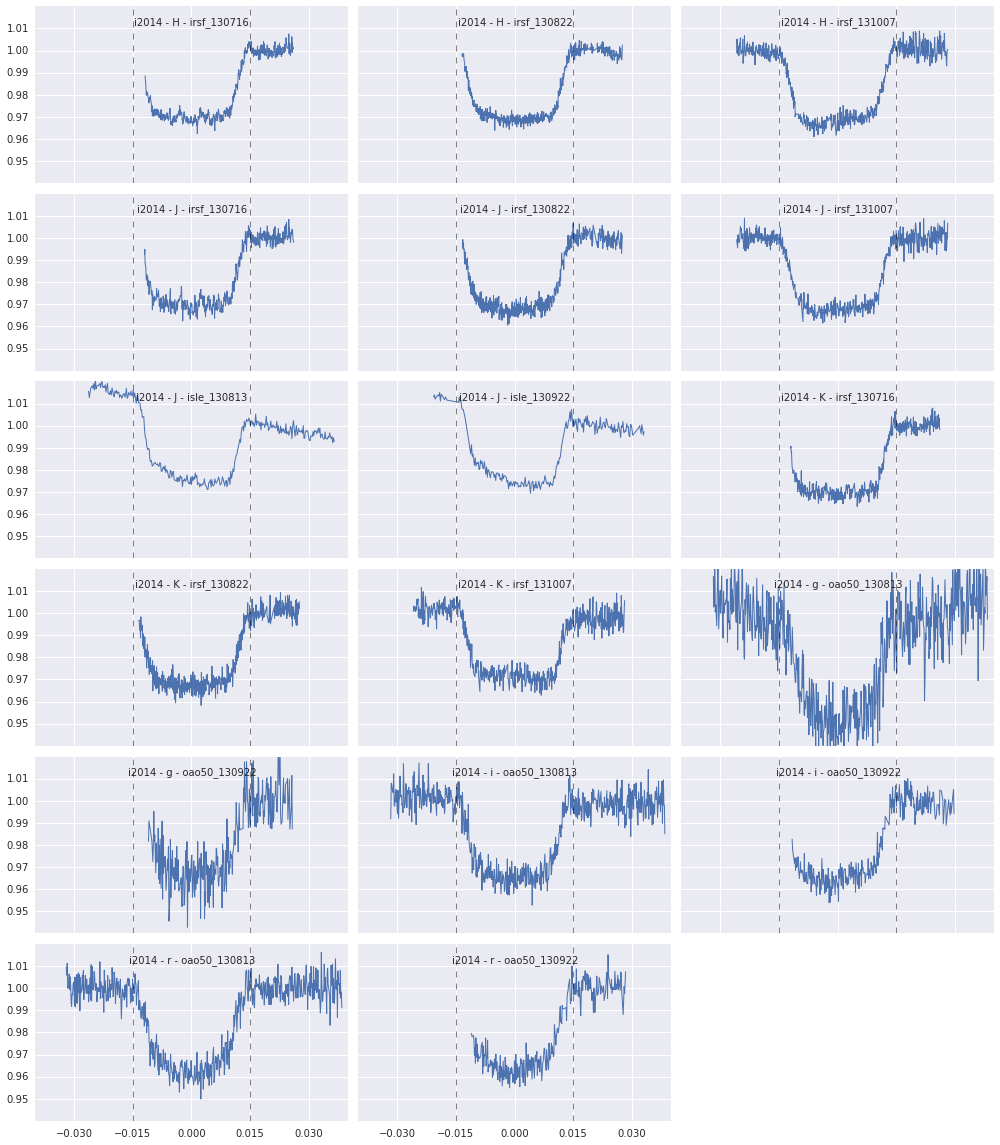

In [7]:
fig,axs = subplots(6,3,figsize=(14,16), sharey=True, sharex=True)
for k,ax in zip(sorted(dfs.keys()),axs.flat):
    df = dfs[k]
    ph = fold(df.index.values, P, TC+TZERO, normalize=True, shift=0.5) - 0.5
    fl = df.flux.values #/ median(df.flux[~df.oe_mask])
    ax.plot(ph, fl, lw=1)
    ax.text(0.5,0.9,k[7:].replace('/',' - '), ha='center', transform=ax.transAxes)
    [ax.axvline(v, ls='--', c='k', lw=1, alpha=0.5) for v in [-0.015,0.015]]
setp(axs, ylim=(0.94,1.02), xlim=(-0.04,0.04), xticks=linspace(-0.03,0.03,5), yticks=linspace(0.95,1.01,7))
fig.tight_layout()
axs.flat[-1].set_visible(False)

## Triaud et al. 2013

Here we prepare the TRAPPIST and EulerCam light curves by Triaud et al. (2013) (Obtained from Vizier, http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/A+A/551/A80&-to=3)

The data contains two TRAPPIST z' light curves and an Euler r' light curve.

In [15]:
dt = array(pf.getdata('data/triaud_2013_trappist.fits', 1)).byteswap().newbyteorder()

In [16]:
df = pd.DataFrame(dt)
df.columns = map(str.lower, df.columns)

In [17]:
mz1 = df.bjd < 6070
mr1 = (df.bjd < 6150) & (~mz1)
mz2 = (~mz1) & (~mr1)
df.bjd += 2450000

In [18]:
fz1 = pd.Series(df[mz1].flux.values, index=df[mz1].bjd.values, name='z_trappist_1')
fz2 = pd.Series(df[mz2].flux.values, index=df[mz2].bjd.values, name='z_trappist_2')
fr1 = pd.Series(df[mr1].flux.values, index=df[mr1].bjd.values, name='r_eulercam_')

In [19]:
f = pd.HDFStore('data/external_lcs.h5')
f.put('lc/triaud2013/z/trappist_1', fz1)
f.put('lc/triaud2013/z/trappist_2', fz2)
f.put('lc/triaud2013/r/eulercam_1', fr1)
f.close()

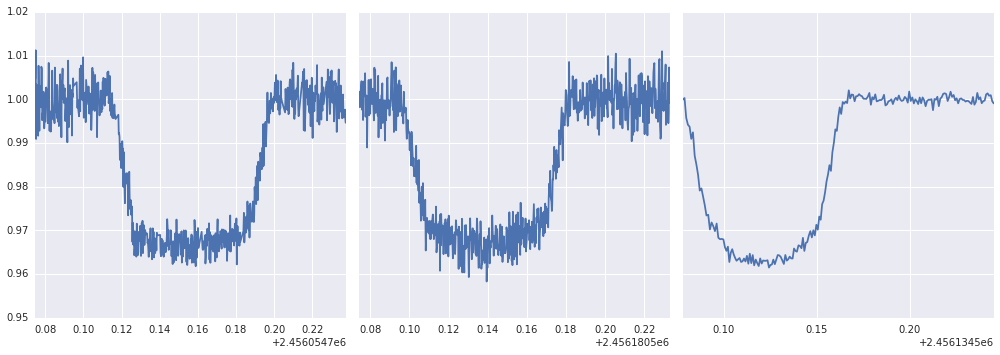

In [20]:
fig, axs = subplots(1,3,figsize=(14,5), sharey=True)
fz1.plot(ax=axs[0])
fz2.plot(ax=axs[1])
fr1.plot(ax=axs[2])
fig.tight_layout()

## Mancini et al. 2014

Mancini et al. Observe a single transit simultaneously with the Danish Telescope (Bessel I) and GROND (g r i z J H K).

In [21]:
DFOSC = ['I']
GROND = 'g r i z J H K'.split()

In [22]:
dm = array(pf.getdata('data/mancini_2014.fits', 1)).byteswap().newbyteorder()
dfm = pd.DataFrame(dm)
dfm.columns = map(str.lower, dm.dtype.names)
dfm.bjd += 2400000
dfm['flux'] = 10**(-dfm.mag/2.5)
dfm.drop(['mag','e_mag'], inplace=True, axis=1)
dfm.sort(['band','bjd'], inplace=True)

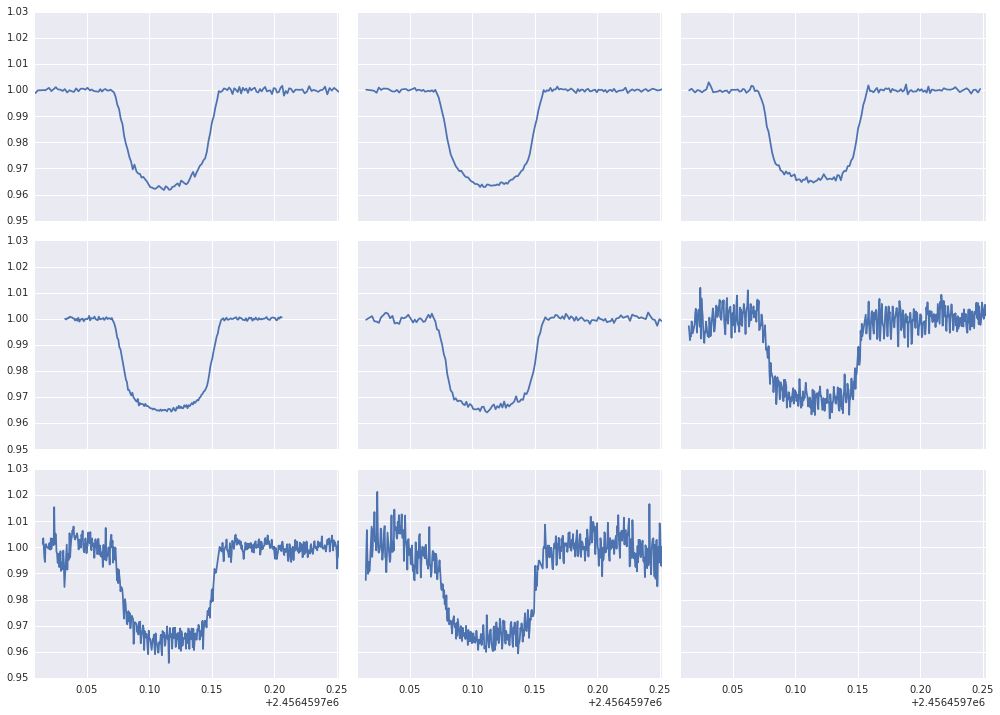

In [23]:
fig,axs = subplots(3,3, figsize=(14,10), sharey=True, sharex=True)
for i,band in enumerate('g r i I z J H K'.split()):
    dft = dfm[dfm.band==band]
    axs.flat[i].plot(dft.bjd, dft.flux)
setp(axs, xlim=[dfm.bjd.min(),dfm.bjd.max()], ylim=(0.95, 1.03))
fig.tight_layout()

In [24]:
f = pd.HDFStore('data/external_lcs.h5','a')
for band in dfm.band.unique():
    inst = 'grond' if band in GROND else 'dfosc'
    band = band.replace('I','i')
    name = 'lc/mancini2014/{band:s}/{name:s}'.format(band=band,name=inst)
    dft = dfm[dfm.band==band]
    f.put(name, pd.Series(dft.flux.values, dft.bjd.values, name=name))
f.close()

## Save the transmission information 

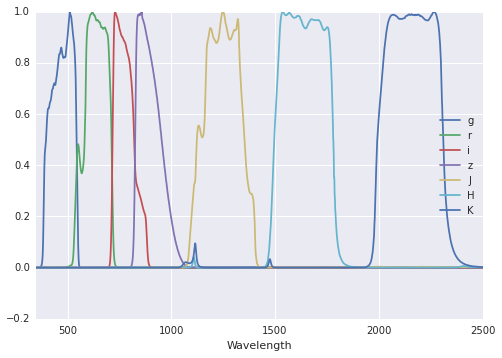

In [14]:
def N(a):
    return a/a.max()

def favg(filters):
    return N(sum(map(N, filters), 0))

dff = pd.read_csv('data/fukui_2014/TM_all.dat', sep=' ')
dff = pd.DataFrame(dff.values[:,1:-1], columns=dff.columns[2:], index=pd.Series(dff.values[:,0], name='Wavelength'))
dfg = pd.read_csv('data/GROND_filters.txt', sep='\t', index_col=0)
dfg.index.name = 'Wavelength'

print list(dff.columns)
print list(dfg.columns)

filter_names = 'g r i z J H K'.split()

transmission = array([favg([dfg.gBand,dff.MITSuME_g]),
                    favg([dfg.rBand,dff.MITSuME_Rc]),
                    favg([dfg.iBand,dff.MITSuME_Ic]),
                    N(dfg.zBand),
                    favg([dfg.JBand,dff['2MASS_J'],dff.IRSF_J]),
                    favg([dfg.HBand,dff.IRSF_H]),
                    favg([dfg.KBand,dff.IRSF_Ks])]).T

ddf = pd.DataFrame(data=transmission, columns=filter_names, index=dfg.index)

ddf.to_hdf('data/external_lcs.h5', 'transmission')

ddf.plot();

In [25]:
f = pd.HDFStore('data/external_lcs.h5')
print f
f.close()

<class 'pandas.io.pytables.HDFStore'>
File path: data/external_lcs.h5
/lc/fukui2014/H/irsf_130716             frame        (shape->[537,7]) 
/lc/fukui2014/H/irsf_130822             frame        (shape->[576,7]) 
/lc/fukui2014/H/irsf_131007             frame        (shape->[597,7]) 
/lc/fukui2014/J/irsf_130716             frame        (shape->[541,7]) 
/lc/fukui2014/J/irsf_130822             frame        (shape->[566,7]) 
/lc/fukui2014/J/irsf_131007             frame        (shape->[597,7]) 
/lc/fukui2014/J/isle_130813             frame        (shape->[324,7]) 
/lc/fukui2014/J/isle_130922             frame        (shape->[241,7]) 
/lc/fukui2014/K/irsf_130716             frame        (shape->[539,7]) 
/lc/fukui2014/K/irsf_130822             frame        (shape->[582,7]) 
/lc/fukui2014/K/irsf_131007             frame        (shape->[603,7]) 
/lc/fukui2014/g/oao50_130813            frame        (shape->[562,7]) 
/lc/fukui2014/g/oao50_130922            frame        (shape->[268,7]) 
/lc/fuk